# Chapter 2
Chapter 2 focuses on the introduction of between-person analysis. The data used in this example are a subset of the [Octogenarian Twin Study of Aging](https://www.maelstrom-research.org/study/octo-twin) dataset. They consist of data from 550 older adults, for which the following measurements were collected:
- age
- cognition (assessed with the Information Test)
- grip strength
- sex
- dementia diagnosis

A review of general linear models (GLM) and Analysis of Variance (ANOVA) methods is provided in this chapter, with a particular focus on the interpretation of interactions among continuous and categorical predictors.

## Import packages

In [51]:
import math
import os

import matplotlib.pyplot as plt
import pandas as pd
from sas7bdat import SAS7BDAT
import scipy.stats
import seaborn as sns
import statsmodels.formula.api
import statsmodels.stats.anova

## Constants

In [2]:
# File paths
FILE_PATH = os.path.join("Data", "SAS_Chapter2.sas7bdat")

# File columns
AGE_COL = "age"
COGNITION_COL = "cognition"
GRIP_COL = "grip"
SEX_COL = "sexMW"
DEMENTIA_GROUP_COL = "demgroup"

## Read data

In [3]:
with SAS7BDAT(FILE_PATH, skip_header=False) as reader:
    df = reader.to_data_frame()

# Between-Person Empty Model
Let's now start our review of between-person analysis methods using an empty model, that does not use any predictor to predict cognition:

$
y_i = \beta_0 + e_i
$

The only parameter that our model needs to determine is the intercept $\beta_0$.

In [4]:
empty_model = statsmodels.formula.api.ols(formula="cognition ~ 1", data=df).fit()
empty_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 28 Aug 2024   Prob (F-statistic):                nan
Time:                        08:37:05   Log-Likelihood:                -2098.2
No. Observations:                 550   AIC:                             4198.
Df Residuals:                     549   BIC:                             4203.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.8218      0.469     52.973      0.000      23.901      25.742
==============================================================================
Omnibus:                       23.202   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.625
Skew:                          -0.260   Prob(JB):                     0.000667
Kurtosis:                       2.393   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see from the results above, the intercept (`24.82`) corresponds to the grand total mean of cognition across all the dataset:

In [5]:
print(f"Grand mean for cognition: {df[COGNITION_COL].mean():.2f}")
print(f"Intercept of the empty model: {empty_model.params.loc["Intercept"]:.2f}")

Grand mean for cognition: 24.82
Intercept of the empty model: 24.82


The variance of the residuals is computed as:

$
\sigma_e^2 = \frac{\sum_{i=1}^N\left(y_i-\hat{y_i}^2\right)}{N-k}
$

where $N$ is the total number of samples, $k$ is the number of effects (1 in this case, since we only have the intercept).

With `statsmodels`, we can retrieve the residual variance by accessing ``empty_model.mse_resid``, and for the empty model it corresponds to 120.76.

In [6]:
print(f"Residual variance for the empty model: {empty_model.mse_resid:.2f}")

Residual variance for the empty model: 120.76


# Between-Person Analysis Using Continuous Predictors

## Age
We expect age to be a good predictor of cognition, with a decrease in cognition as age progresses. We can then build a model that uses age to predict the cognition. 

Since the samples of our dataset contain data from people with age > 80, we need to center the age predictor in order to have a meaningful 0 value: we will use 85 as a 0 value.
We substract this value to create a new variable named `centered_age`, and we will use it in our models.

In [7]:
CENTERED_AGE_COL = "centered_age"
df[CENTERED_AGE_COL] = df[AGE_COL] - 85

Let's now fit the model using centered_age as a predictor.

In [8]:
age_model = statsmodels.formula.api.ols(formula=f"{COGNITION_COL} ~ {CENTERED_AGE_COL}", data=df).fit()
age_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     16.40
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           5.87e-05
Time:                        08:37:05   Log-Likelihood:                -2090.1
No. Observations:                 550   AIC:                             4184.
Df Residuals:                     548   BIC:                             4193.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.7818      0.462     53.612      0.000      23.874      25.690
centered_age    -0.5461      0.135     -4.049      0.000      -0.811      -0.281
==============================================================================
Omnibus:                       19.700   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.788
Skew:                          -0.238   Prob(JB):                      0.00167
Kurtosis:                       2.425   Cond. No.                         3.43
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The coefficient for centered_age is equal to -0.5461, and as expected it is a negative coefficient, meaning that there is a decline in cognition as age progresses. In particular, for a one-unit change in age, there is an expected decrease in cognition of -0.5461.

The intercept value (now equal to 24.7818) corresponds to the expected cognition value for a person with 85 years old, since our 0 is now 85 years

The $R^2$ of the model that uses age as a unique predictor is 0.03. Another way to get to the same value it's by computing the relative change in residual variance with respect to the empty model:

```
(age_model.mse_resid - empty_model.mse_resid)/empty_model.mse_resid
```


In [9]:
print(f"{(empty_model.mse_resid-age_model.mse_resid)/empty_model.mse_resid:.2f}")

0.03


In order to determine if the age coefficient is significat, we need to compute the standard error for the coefficient. The standard error for a coefficient is defined as:

$
SE_{\beta_X} = \sqrt{\frac{Var(y_i)*(1-R_Y^2)}{Var(x_i)*(1-R_x^2)*(N-k)}}
$

Thus, the standard error ($SE$) for a predictor depends on the amount of variance in the outcome variable that is still remaining in the model

In [10]:
# SE numerator
se_num = df[COGNITION_COL].std()**2*(1-((empty_model.mse_resid-age_model.mse_resid)/empty_model.mse_resid))
# SE denominator
se_den = (df[AGE_COL].std()**2)*(1-0)*(len(df)-1)
# Compute SE
se = math.sqrt(se_num/se_den)
print(f"SE: {se:.3f}")

SE: 0.135


In order to determine if the slope is significantly different from $0$, we can run what it's called a Wald test. We compute the ratio between the coefficient and its standard error (SE), and compare it a t-distribution to determine if the age slope is different from 0.

In [11]:
t_statistic = age_model.params.loc[CENTERED_AGE_COL]/se
print(f"t-statistic: {t_statistic:.4f}")

t-statistic: -4.0494


In [12]:
critical_value = scipy.stats.t.ppf(0.025,len(df)-2)
print(t_statistic < critical_value)

True


We can also determine the confidence interval for the estimate of the coefficient, defined as $\beta_1\pm1.96*SE$:

In [13]:
print(f"Age coefficient CI: ({age_model.params.loc[CENTERED_AGE_COL]-1.96*se:.4f},{age_model.params.loc[CENTERED_AGE_COL]+1.96*se:.4f})")

Age coefficient CI: (-0.8104,-0.2818)


## Age and Grip
In addition to age, we can include another predictor in the model that is the grip strength. Similar to what we did for age, we need to properly center the grip strength. Since we have a mean of around 9 pounds, we use this value as a center point. Now, our model looks like this:

$
Cognition_i = \beta_0 + \beta_1(Age_i-85)+\beta_2(Grip_i-9)+e_i
$

In [14]:
CENTERED_GRIP_COL = "centered_grip"
df[CENTERED_GRIP_COL] = df[GRIP_COL] - 9

In [15]:
age_grip_model = statsmodels.formula.api.ols(formula=f"""{COGNITION_COL} ~ 
                                             {CENTERED_AGE_COL} + 
                                             {CENTERED_GRIP_COL}""", data=df).fit()
age_grip_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     22.14
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           5.66e-10
Time:                        08:37:05   Log-Likelihood:                -2076.8
No. Observations:                 550   AIC:                             4160.
Df Residuals:                     547   BIC:                             4173.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        24.7008      0.452     54.662      0.000      23.813      25.588
centered_age     -0.4176      0.134     -3.115      0.002      -0.681      -0.154
centered_grip     0.8025      0.154      5.206      0.000       0.500       1.105
==============================================================================
Omnibus:                       17.496   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.268
Skew:                          -0.248   Prob(JB):                      0.00217
Kurtosis:                       2.462   Cond. No.                         3.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, the intercept is the expected cognition level for a person of 85 years old with 9 pounds grip strength. In addition to this, the slope for age ($-0.4176$) is less than the previous one, since we have a correlation with grip strength in the dataset.

With the grip strength coefficient of 0.80, we expect cognition to increase of 0.8 for every additional year of age.

In [16]:
df.loc[:,[CENTERED_AGE_COL, CENTERED_GRIP_COL]].corr()

,centered_age,centered_grip
centered_age,1.000000,-0.184135
centered_grip,-0.184135,1.000000


The reduction in the residual variance with respect to the empty model is now equal to $0.07$.

In [17]:
print(f"{(empty_model.mse_resid-age_grip_model.mse_resid)/empty_model.mse_resid:.2f}")

0.07


# Between-Person Analysis Using Categorical Predictors

## Model with sex

In addition to continuous predictors, such as age and grip strength, which were included in the previous models, we have categorical predictors (i.e., analysis of covariance). One factor that we may include in our model is sex. Let's see first the distribution of sex values in the dataset before including it.

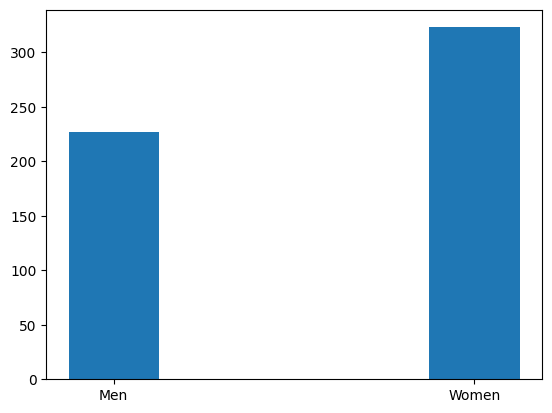

In [18]:
ax = df[SEX_COL].hist(bins=[0,.2,.8,1], grid=False)
ax.set_xticks([0.1, 0.9],["Men","Women"]);

In [19]:
df[SEX_COL].value_counts(normalize=True)

sexMW
1.0    0.587273
0.0    0.412727
Name: proportion, dtype: float64

We now create a dummy variable that is 0 for men and 1 for women, so that the intercept of the model can still be interpretable. In `pandas` we can do this with the categorical data type.

In [20]:
sex_categorical = pd.CategoricalDtype(categories=[0,1],ordered=True)
df[SEX_COL] = df[SEX_COL].astype(sex_categorical)

In [21]:
sex_model = statsmodels.formula.api.ols(formula=f"""{COGNITION_COL} ~
                                                {CENTERED_AGE_COL} + 
                                                {CENTERED_GRIP_COL} + 
                                                {SEX_COL}
                                                """, data=df).fit()
sex_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     20.04
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           2.48e-12
Time:                        08:37:08   Log-Likelihood:                -2069.5
No. Observations:                 550   AIC:                             4147.
Df Residuals:                     546   BIC:                             4164.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        26.9594      0.739     36.487      0.000      25.508      28.411
sexMW[T.1]       -3.7988      0.990     -3.836      0.000      -5.744      -1.853
centered_age     -0.4338      0.132     -3.275      0.001      -0.694      -0.174
centered_grip     0.5460      0.166      3.284      0.001       0.219       0.873
==============================================================================
Omnibus:                       16.621   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.935
Skew:                          -0.210   Prob(JB):                      0.00422
Kurtosis:                       2.452   Cond. No.                         9.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results from the model which includes sex among the predictors now show that the estimated effect for sex is -3.80, indicating that women are predicted to have significantly lower cognition of men by 3.8.

The intercept of the model now must be interpreted as the axpected cognition for a man who is 85 years old and has a grip strength of 9 poinds.

By including the sex among the predictors, the residual variance was reduced of $9\%$.

The effect of grip was reduced from $0.8$ to $0.54$ (with an increase in its standard error) since we have correlation between sex and grip strength, while the correlation between age and grip strength is low and thus the effect of age and its SE are similar to the previous model.

In [22]:
df.loc[:, [CENTERED_AGE_COL, CENTERED_GRIP_COL, SEX_COL]].corr()

,centered_age,centered_grip,sexMW
centered_age,1.000000,-0.184135,0.045597
centered_grip,-0.184135,1.000000,-0.403243
sexMW,0.045597,-0.403243,1.000000


## Model with dementia

In addition to age, grip strength, and sex, le latest predictor that we consider is the dementia diagnosis during the rest of the longitudinal study. Three different diagnosis will be considered:
- people not diagnosed with dementia (72.55%), group **none**
- people diagnosed with dementia in the future (19.82%), group **future**
- people already diagnosed with dementia (7.64%), group **current**

In [23]:
df[DEMENTIA_GROUP_COL].value_counts(normalize=True)

demgroup
1.0    0.725455
2.0    0.198182
3.0    0.076364
Name: proportion, dtype: float64

We create two dummy variables to code the dementia diagnosis, selecting the **none** group as the reference group since it is the largest in the sample.

In [24]:
dementia_categorical = pd.CategoricalDtype(categories=[1,2,3],ordered=True)


df[DEMENTIA_GROUP_COL] = df[DEMENTIA_GROUP_COL].astype(dementia_categorical)
age_grip_sex_dem_model = statsmodels.formula.api.ols(formula=f"""
                                             {COGNITION_COL} ~ 
                                             {CENTERED_AGE_COL} + 
                                             {CENTERED_GRIP_COL} + 
                                             {SEX_COL} + 
                                             {DEMENTIA_GROUP_COL}
                                             """, data=df).fit()
age_grip_sex_dem_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     41.75
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           2.16e-36
Time:                        08:37:08   Log-Likelihood:                -2008.9
No. Observations:                 550   AIC:                             4030.
Df Residuals:                     544   BIC:                             4056.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        29.2643      0.699     41.895      0.000      27.892      30.636
sexMW[T.1]       -3.6574      0.891     -4.103      0.000      -5.408      -1.906
demgroup[T.2]    -5.7220      1.019     -5.615      0.000      -7.724      -3.720
demgroup[T.3]   -16.4798      1.523    -10.822      0.000     -19.471     -13.489
centered_age     -0.4057      0.119     -3.412      0.001      -0.639      -0.172
centered_grip     0.6042      0.150      4.034      0.000       0.310       0.898
==============================================================================
Omnibus:                       10.382   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                8.535
Skew:                          -0.223   Prob(JB):                       0.0140
Kurtosis:                       2.583   Cond. No.                         13.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Given the coding that we did on the dementia group, the summary of the results show the significant tests for each specific group contrast separately. We may be interested in whether there are significant differences across the groups in general, i.e. in the omnibus effect of dementia group. 

With statsmodels, in order to get the omnibus effect, we need to retrieve the results of the Wald tests. For the dementia group, we see that the result is $F(2, 544) = 67.06, p < .001$, thus meaning that we have a significant omnibus effect of dementia group on cognition.

In [25]:
age_grip_sex_dem_model.wald_test_terms(scalar=True)

<class 'statsmodels.stats.contrast.WaldTestResults'>
                         F            P>F  df constraint  df denom
Intercept      1755.231343  2.112191e-172              1     544.0
sexMW            16.833009   4.706929e-05              1     544.0
demgroup         67.055657   9.311747e-27              2     544.0
centered_age     11.645005   6.916503e-04              1     544.0
centered_grip    16.274797   6.263041e-05              1     544.0

With the approach that we just saw, we are missing the comparison between the **current** and the **future** dementia groups, as the results of our model only reports the comparison between **current** and **none** and **future** and **none**. In order to get also the comparison between the two missing groups, we need to change our reference group and re-run the model estimation.

In [26]:
dementia_categorical = pd.CategoricalDtype(categories=[2,3,1],ordered=True)


df[DEMENTIA_GROUP_COL] = df[DEMENTIA_GROUP_COL].astype(dementia_categorical)
age_grip_sex_dem_model = statsmodels.formula.api.ols(formula=f"""
                                             {COGNITION_COL} ~ 
                                             {CENTERED_AGE_COL} + 
                                             {CENTERED_GRIP_COL} + 
                                             {SEX_COL} + 
                                             {DEMENTIA_GROUP_COL}
                                             """, data=df).fit()
age_grip_sex_dem_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     41.75
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           2.16e-36
Time:                        08:37:08   Log-Likelihood:                -2008.9
No. Observations:                 550   AIC:                             4030.
Df Residuals:                     544   BIC:                             4056.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.5424      1.079     21.828      0.000      21.424      25.661
sexMW[T.1]       -3.6574      0.891     -4.103      0.000      -5.408      -1.906
demgroup[T.3]   -10.7578      1.708     -6.299      0.000     -14.113      -7.403
demgroup[T.1]     5.7220      1.019      5.615      0.000       3.720       7.724
centered_age     -0.4057      0.119     -3.412      0.001      -0.639      -0.172
centered_grip     0.6042      0.150      4.034      0.000       0.310       0.898
==============================================================================
Omnibus:                       10.382   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                8.535
Skew:                          -0.223   Prob(JB):                       0.0140
Kurtosis:                       2.583   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Interpreting Interactions Among Continuous Predictors
The idea that the effect of a model predictor depends on another model predicto is referred to as **moderation**, and we can exploit by adding an interaction term between the two predictors. Given that we add an interaction term, main effects must be interpreted conditionally on its interacting predictor, not marginally as when they are included only as main effects.

## Age and Grip Interaction
Now we are going to fit a model that contains an interaction term between age and grip strength. Given that we have this interaction term, the interpretation of the coefficients for age and grip strength will change, and we need to interpret main coefficients conditionally on their interacting predictor, and not marginally as when they are included only as main effects.

In [43]:
dementia_categorical = pd.CategoricalDtype(categories=[1,2,3],ordered=True)

df[DEMENTIA_GROUP_COL] = df[DEMENTIA_GROUP_COL].astype(dementia_categorical)

age_grip_int_model = statsmodels.formula.api.ols(formula=f"""
                                             {COGNITION_COL} ~ 
                                             {CENTERED_AGE_COL} + 
                                             {CENTERED_GRIP_COL} + 
                                             {SEX_COL} + 
                                             {DEMENTIA_GROUP_COL} +
                                             {CENTERED_AGE_COL}*{CENTERED_GRIP_COL}
                                             """, data=df).fit()

age_grip_int_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.85
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.66e-37
Time:                        10:10:25   Log-Likelihood:                -2004.3
No. Observations:                 550   AIC:                             4023.
Df Residuals:                     543   BIC:                             4053.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     29.4078      0.695     42.319      0.000      28.043      30.773
sexMW[T.1]                    -3.4556      0.887     -3.895      0.000      -5.199      -1.713
demgroup[T.2]                 -5.9225      1.014     -5.843      0.000      -7.914      -3.931
demgroup[T.3]                -16.3004      1.513    -10.777      0.000     -19.272     -13.329
centered_age                  -0.3340      0.120     -2.775      0.006      -0.570      -0.098
centered_grip                  0.6194      0.149      4.164      0.000       0.327       0.912
centered_age:centered_grip     0.1230      0.041      3.035      0.003       0.043       0.203
==============================================================================
Omnibus:                        9.621   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.683
Skew:                          -0.199   Prob(JB):                       0.0215
Kurtosis:                       2.579   Cond. No.                         39.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The interpretation of the intercept, sex and dementia diagnosis coefficients do not change after including the age by grip strength interaction. We refer to effects that do not have any interaction term as **unconditional main effects** or **marginal main effects**.

The coefficients for which the interpretation changed are the age and grip strength: previously, these coefficients were interpreted as the expected difference in cognition for a one unit change in age or grip strength, and these effects were expected to hold equally across all the sample (i.e., they were **unconditional**). Now, these effects became **simple conditional main effects**, meaning that they become the effect of the predictor when their interacting predictor is 0. The simple main effect of age (-0.33), means that we expect cognition to become lower by 0.33 for every year of age only for a person with a grip strength of 9 (as grip strength is centered on 9).

The same reasoning holds for the effect of grip strength: we expect cognition to become higher of 0.62 for every additional pound of grip strength specifically for a person of 85 years old (as age is centered around 85).

We can see from the description provided above that is important to have meaningful **centering** values in order to correctly interpret marginal main effects!

### Interaction Coefficients Modify Their Simple Main Effects
Now, it's time to analyze the interaction coefficient between age and grip strength. The interaction coefficient is equal to 0.1230, and the inclusion of this interaction term reduced the residual variance from the previous value of:

In [44]:
print(f"Residual variance for the model: {age_grip_int_model.mse_resid:.2f}")

Residual variance for the model: 86.76


The new residual variance (86.76) is now lower with respect to the variance of the previous model (without the interaction term):

In [30]:
print(f"Residual variance for the model without the interaction term: {age_grip_sex_dem_model.mse_resid:.2f}")

Residual variance for the model without the interaction term: 88.07


We can also derive the $R^2$ of the model with the interaction term by computing the difference in the residual variance with respect to the empty model:

In [45]:
print(f"R2 of model with interaction term: {(empty_model.mse_resid-age_grip_int_model.mse_resid)/(empty_model.mse_resid):.3f}")

R2 of model with interaction term: 0.282


The model with the interaction term reduced the residual variance of approximately 28% with respect to the empty model.

But, how do we interpret the interaction terms? If the main effects change the intercept of the model, the role of the interaction terms is to change the slope of the simple main effects. The interaction term operates inderectly on the intercept, by adjusting the value of the simple main effects (which, in turn, have an effect on the intercept). When describing the interaction term, there are two possibile ways to describe it, that it is how each simple main effect depends on the value of the interacting predictor. Both interpretations are always correct, but one may be more convenient than the other depending on the model.

In this case, one way to interpret the interaction coefficient is to describe how the effect of age depends on grip strength. We start with the simple main effect of age (-0.33) as evaluated when grip strength is 9. We have that for every additional pound of grip strength, the simple main effect of age becomes less negative of 0.12 (the value of the interaction coefficient). Thus, we have that the interaction term weakens the effect of age (the age slope is less negative in stronger people by 0.12 per pound of grip strength).

The other way to interpret the interaction coefficient is to describe how the effect of grip strength depends on age. Again, we start with the simple main effect of grip strength (0.62). We have that for every additional year of age, the grip strength slope becomes more positive by the interaction term 0.12: the interaction term strengthens the effect of grip strength, meaning that the expected change in cognition for each pound of grip strength in higher in older people.

### Re-centering Main Effects To Decompose Interactions
In addition to the interpretation provided above, another way to interpret the interaction term is by re-centering the main effects and analyzing the new coefficient values. By taking the first derivative of the model with respect to age and grip strength, we obtain:

Age slope $= \beta_1 + \beta_6(Grip-9)$

Grip strength slope $= \beta_2 + \beta_6(Age-85)$

We can then take a look at the values of the age slope and grip strength slope under different points of grip strength and age.

Age slope at grip strength of 6: $\beta_{1,new} = -0.33+(0.12-3)=-0.7$

Age slope at grip strength of 9: $\beta_{1,new} = -0.33+(0.12-3)=-0.33$

Age slope at grip strength of 12: $\beta_{1,new} = -0.33+(0.12-3)=-0.04$

Grip strength slope at age 80: $\beta_{1,new} = 0.62+(0.12*(-5))=0.00$

Grip strength slope at age 85: $\beta_{1,new} = 0.62+(0.12*0)=-0.62$

Grip strength slope at age 90: $\beta_{1,new} = 0.62+(0.12*5)=1.23$

The age slope becomes less negative by the interaction term 0.12, and for each additional year of age the grip strength becomes more positive by the interaction 0.12. By doing this, we can extract the value of the slope coefficients under any centering constant, but we cannot determine the standard errors of the new coefficients. In order to do this, we need to refit the model by changing the centering points of the predictors. In this case, given that we have a negative correlation between age and grip, we can consider younger and stronger person to create a second reference point, and older and weaker persons to create a third reference point. In this way, we can determine the standard errors of the new coefficients as evaluated at specific values for the interacting predictors.


#### Younger and stronger persons

In [39]:
df["age_80"] = df[AGE_COL] - 80
df["age_90"] = df[AGE_COL] - 90
df["grip_6"] = df[GRIP_COL] - 6
df["grip_12"] = df[GRIP_COL] - 12

model = statsmodels.formula.api.ols(formula=f"""
                                             {COGNITION_COL} ~ 
                                             age_80 + 
                                             grip_12 +
                                             {SEX_COL} + 
                                             {DEMENTIA_GROUP_COL} +
                                             age_80*grip_12
                                             """, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.85
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.66e-37
Time:                        09:56:56   Log-Likelihood:                -2004.3
No. Observations:                 550   AIC:                             4023.
Df Residuals:                     543   BIC:                             4053.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         31.0906      1.092     28.461      0.000      28.945      33.236
sexMW[T.1]        -3.4556      0.887     -3.895      0.000      -5.199      -1.713
demgroup[T.2]     -5.9225      1.014     -5.843      0.000      -7.914      -3.931
demgroup[T.3]    -16.3004      1.513    -10.777      0.000     -19.272     -13.329
age_80             0.0351      0.187      0.188      0.851      -0.333       0.403
grip_12            0.0043      0.247      0.017      0.986      -0.482       0.490
age_80:grip_12     0.1230      0.041      3.035      0.003       0.043       0.203
==============================================================================
Omnibus:                        9.621   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.683
Skew:                          -0.199   Prob(JB):                       0.0215
Kurtosis:                       2.579   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Older and weaker persons

In [40]:
model = statsmodels.formula.api.ols(formula=f"""
                                             {COGNITION_COL} ~ 
                                             age_90 + 
                                             grip_6 +
                                             {SEX_COL} + 
                                             {DEMENTIA_GROUP_COL} +
                                             age_90*grip_6
                                             """, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cognition   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     36.85
Date:                Wed, 28 Aug 2024   Prob (F-statistic):           1.66e-37
Time:                        09:57:57   Log-Likelihood:                -2004.3
No. Observations:                 550   AIC:                             4023.
Df Residuals:                     543   BIC:                             4053.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        24.0345      1.149     20.916      0.000      21.777      26.292
sexMW[T.1]       -3.4556      0.887     -3.895      0.000      -5.199      -1.713
demgroup[T.2]    -5.9225      1.014     -5.843      0.000      -7.914      -3.931
demgroup[T.3]   -16.3004      1.513    -10.777      0.000     -19.272     -13.329
age_90           -0.7030      0.153     -4.584      0.000      -1.004      -0.402
grip_6            1.2345      0.255      4.833      0.000       0.733       1.736
age_90:grip_6     0.1230      0.041      3.035      0.003       0.043       0.203
==============================================================================
Omnibus:                        9.621   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                7.683
Skew:                          -0.199   Prob(JB):                       0.0215
Kurtosis:                       2.579   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the results of the above model, we can see that the interaction of age and grip strength didn't change, as well as the main effects of sex and dementia. What did change are the intercept and the simple main effects of age and grip strength, because they are conditional on the value of the interacting predictor. 

The coefficients, with the different centering points, now have a standard error and a p-value associated with them, and thus we can determine when age and grip strength matter. We have that in weaker persons (grip strength = 6), age does matter, while in stronger persons it does not matter. In young persons, grip strength doesn't matter, but it does in older persons.

### Plotting Interactions Using Hypotethical People
In addition to re-centering the predictors, another way that we can use is to illustrate how the slopes of the predictors are moderated by each other. We can do this by plotting interactions via hypotethical people. When doing so, we keep the main effects of sex and dementia fixed, and we vary the values of the interacting predictors, in this case age and grip strength.

In [57]:
new_people = pd.DataFrame({
    AGE_COL: [80,85,90,80,85,90,80,85,90],
    GRIP_COL: [12,12,12,9,9,9,6,6,6],
    CENTERED_AGE_COL: [-5,0,5,-5,0,5,-5,0,5],
    CENTERED_GRIP_COL: [3,3,3,0,0,0,-3,-3,-3],
    SEX_COL: [0 for __ in range(9)],
    DEMENTIA_GROUP_COL: [1 for __ in range(9)],
})
new_people[COGNITION_COL] = age_grip_int_model.predict(new_people)

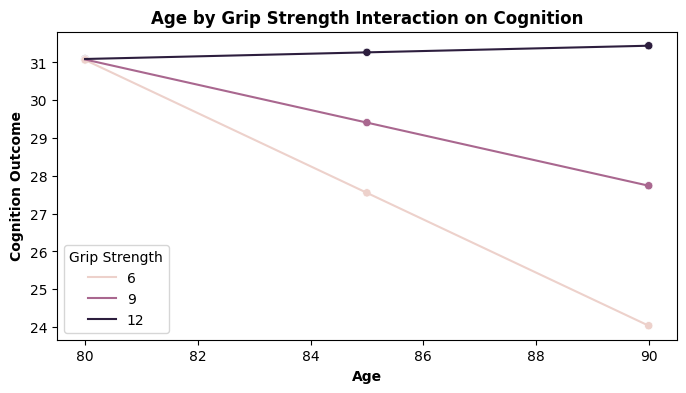

In [71]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(data=new_people, x=AGE_COL,hue=GRIP_COL,y=COGNITION_COL)
ax = sns.scatterplot(data=new_people, x=AGE_COL,hue=GRIP_COL,y=COGNITION_COL, legend=False)
ax.set_title("Age by Grip Strength Interaction on Cognition", fontweight="bold")
ax.set_xlabel("Age", fontweight="bold")
ax.set_ylabel("Cognition Outcome", fontweight="bold")
ax.legend(title="Grip Strength");

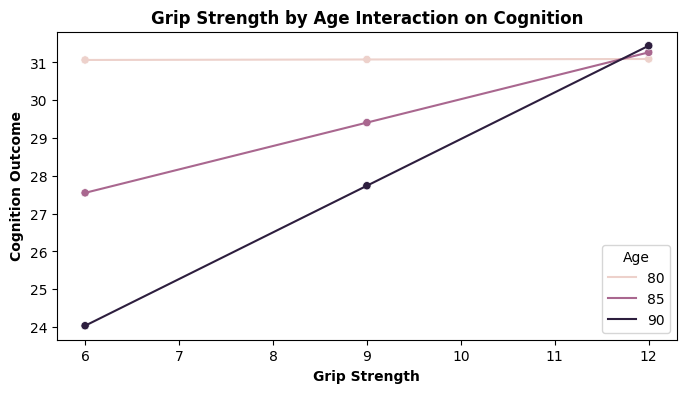

In [72]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax = sns.lineplot(data=new_people, x=GRIP_COL,hue=AGE_COL,y=COGNITION_COL)
ax = sns.scatterplot(data=new_people, x=GRIP_COL,hue=AGE_COL,y=COGNITION_COL, legend=False)
ax.set_title("Grip Strength by Age Interaction on Cognition", fontweight="bold")
ax.set_xlabel("Grip Strength", fontweight="bold")
ax.set_ylabel("Cognition Outcome", fontweight="bold")
ax.legend(title="Age");

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.lineplot(data=new_people, x=GRIP_COL,hue=AGE_COL,y=COGNITION_COL)

### Assessing Regions of Significance of Main Effects Within Interactions
In the previous section, we analyzed the differences in significance of the simple main effects. A follow-up analysis would be the identification of the range of values for which a simple main effect is significant. 

We can then determine the threshold values of the interacting predictor after which its simple main effect becomes nonsignificant.

# Interpreting Interactions Involving Categorical Predictors